<a href="https://colab.research.google.com/github/ammarameenn/Object-Detection/blob/main/ACTIVITY_RECOGNITION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# Downloading the UCF50 dataset.
!wget --no-check-certificate "https://www.crcv.ucf.edu/data/UCF50.rar"

--2023-02-08 10:40:06--  https://www.crcv.ucf.edu/data/UCF50.rar
Resolving www.crcv.ucf.edu (www.crcv.ucf.edu)... 132.170.214.127
Connecting to www.crcv.ucf.edu (www.crcv.ucf.edu)|132.170.214.127|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 3233554570 (3.0G) [application/rar]
Saving to: ‘UCF50.rar’

UCF50.rar           100%[===================>]   3.01G  7.45MB/s    in 4m 43s  

2023-02-08 10:44:50 (10.9 MB/s) - ‘UCF50.rar’ saved [3233554570/3233554570]



In [6]:
# Extracting the dataset in the folder
!unrar x UCF50.rar

Streaming output truncated to the last 5000 lines.
Extracting  UCF50/HorseRace/v_HorseRace_g16_c03.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g16_c04.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g16_c05.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g17_c01.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g17_c02.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g17_c03.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g17_c04.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g17_c05.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g18_c01.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g18_c02.avi                       23%  OK 
Extracting  UCF50/HorseRace/v

In [1]:
import os
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping

In [7]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [8]:
all_classes_names = os.listdir('UCF50')

In [9]:
all_classes_names

['Mixing',
 'JumpRope',
 'WalkingWithDog',
 'Swing',
 'RockClimbingIndoor',
 'Nunchucks',
 'GolfSwing',
 'TennisSwing',
 'Diving',
 'JugglingBalls',
 'SalsaSpin',
 'PlayingViolin',
 'Punch',
 'HighJump',
 'BreastStroke',
 'Biking',
 'Basketball',
 'PlayingTabla',
 'Billiards',
 'PushUps',
 'PizzaTossing',
 'Lunges',
 'Fencing',
 'BenchPress',
 'TrampolineJumping',
 'BaseballPitch',
 'PlayingPiano',
 'PullUps',
 'PlayingGuitar',
 'JavelinThrow',
 'MilitaryParade',
 'YoYo',
 'Skijet',
 'VolleyballSpiking',
 'SkateBoarding',
 'HorseRiding',
 'Rowing',
 'RopeClimbing',
 'Kayaking',
 'PommelHorse',
 'ThrowDiscus',
 'CleanAndJerk',
 'HulaHoop',
 'HorseRace',
 'JumpingJack',
 'Skiing',
 'Drumming',
 'PoleVault',
 'SoccerJuggling',
 'TaiChi']

In [14]:
random_range = random.sample(range(len(all_classes_names)),20)

In [15]:
random_range

[48, 19, 47, 2, 43, 33, 5, 10, 29, 9, 16, 34, 3, 11, 0, 28, 40, 22, 26, 46]

In [16]:
selected = all_classes_names[random_range[0]]

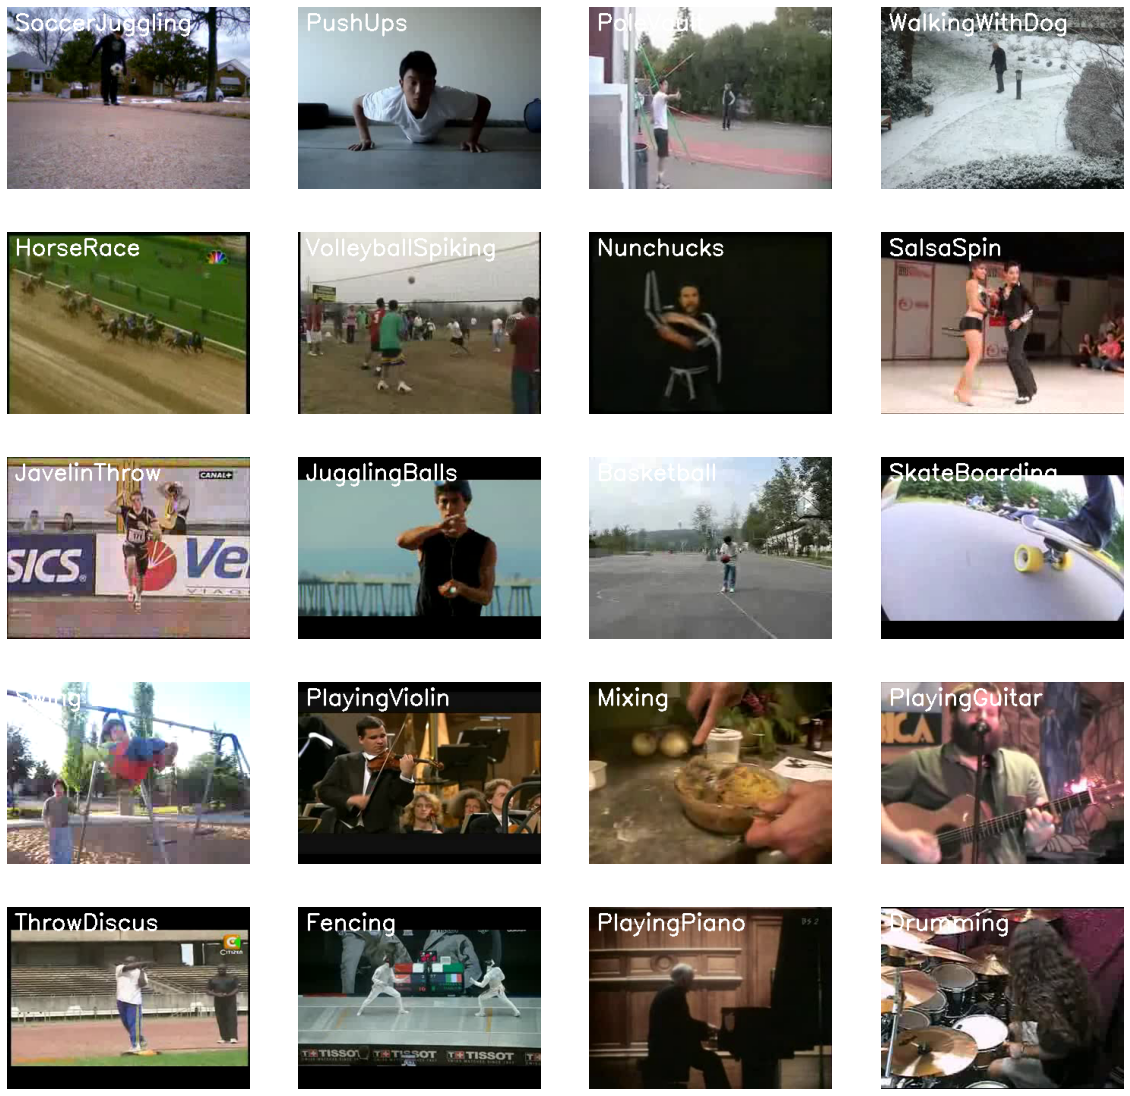

In [17]:
plt.figure(figsize = (20,20))
for counter, random_index in enumerate(random_range, 1):
  selected_class_name = all_classes_names[random_index]
  video_file_name_list = os.listdir(f'UCF50/{selected_class_name}')
  selected_video_file_name =random.choice(video_file_name_list)
  video_reader = cv2.VideoCapture(f'UCF50/{selected_class_name}/{selected_video_file_name}')
  rr, bgr_frame = video_reader.read()
  video_reader.release()
  rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
  cv2.putText(rgb_frame, selected_class_name, (10,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
  plt.subplot(5,4, counter)
  plt.imshow(rgb_frame)
  plt.axis('off')

In [18]:
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64
SEQUENCE_LENGTH = 20
DATASET_DIR = 'UCF50'
CLASSES_LIST = ['JugglingBalls','Nunchucks', 'ThrowDiscus', 'PushUps', 'Basketball']

In [19]:
def frames_extraction(video_path):
  frames_list = []
  video_reader = cv2.VideoCapture(video_path)
  video_frame_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
  skip_frames_window = max(int(video_frame_count/SEQUENCE_LENGTH), 1)
  for frame_counter in range(SEQUENCE_LENGTH):
    video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter*skip_frames_window)
    success, frame = video_reader.read()

    if not success:
      break

    resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
    normalized_frame = resized_frame / 255
    frames_list.append(normalized_frame)

  video_reader.release()

  return frames_list

In [20]:
def create_dataset():
  features = []
  labels = []
  video_files_paths = []

  for class_index, class_name in enumerate(CLASSES_LIST):

    print(f'Extracting Data of class: {class_name}')

    files_list = os.listdir(os.path.join(DATASET_DIR,class_name))

    for file_name in files_list:

      video_file_path = os.path.join(DATASET_DIR,class_name, file_name)

      frames = frames_extraction(video_file_path)

      if len(frames) == SEQUENCE_LENGTH:

        features.append(frames)
        labels.append(class_index)
        video_files_paths.append(video_file_path)

  features = np.asarray(features)
  labels = np.asarray(labels)

  return features, labels, video_files_paths

In [21]:
features, labels, video_files_paths = create_dataset()

Extracting Data of class: JugglingBalls
Extracting Data of class: Nunchucks
Extracting Data of class: ThrowDiscus
Extracting Data of class: PushUps
Extracting Data of class: Basketball


In [22]:
one_hot_encoded_labels = to_categorical(labels)

In [23]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.25, shuffle = True,
                                                                            random_state = seed_constant)

In [25]:
def CNNLSTM():


  model = Sequential()

  model.add(TimeDistributed(Conv2D(16, (3,3), padding ='same', activation = 'relu'),
                            input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
  model.add(TimeDistributed(MaxPooling2D((4,4))))
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Conv2D(32, (3,3), padding ='same', activation = 'relu')))
  model.add(TimeDistributed(MaxPooling2D((4,4))))
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Conv2D(64, (3,3), padding ='same', activation = 'relu')))
  model.add(TimeDistributed(MaxPooling2D((2,2))))
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Conv2D(64, (3,3), padding ='same', activation = 'relu')))
  model.add(TimeDistributed(MaxPooling2D((2,2))))

  model.add(TimeDistributed(Flatten()))

  model.add(LSTM(32))

  model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

  model.summary()

  return model

In [27]:
CNNLSTM_Model = CNNLSTM()

print('Model Created Successfully')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_12 (TimeDi  (None, 20, 64, 64, 16)   448       
 stributed)                                                      
                                                                 
 time_distributed_13 (TimeDi  (None, 20, 16, 16, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, 20, 16, 16, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 20, 16, 16, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_16 (TimeDi  (None, 20, 4, 4, 32)    

In [30]:
plot_model(model = CNNLSTM, show_layer_names = True) 

AttributeError: ignored

In [34]:
#early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

CNNLSTM_Model.compile(loss = 'categorical_crossentropy', optimizer= 'Adam', metrics = ["accuracy"])

In [35]:
CNNLSTM_Model_history = CNNLSTM_Model.fit(x = features_train, y = labels_train, epochs = 200, batch_size = 4,
                                          shuffle = True, validation_split = 0.2)

Epoch 1/200
97/97 [==============================] - 4s 16ms/step - loss: 0.0650 - accuracy: 0.9871 - val_loss: 0.4400 - val_accuracy: 0.9072
Epoch 2/200
97/97 [==============================] - 1s 9ms/step - loss: 0.0097 - accuracy: 0.9974 - val_loss: 0.4283 - val_accuracy: 0.9072
Epoch 3/200
97/97 [==============================] - 1s 9ms/step - loss: 0.0049 - accuracy: 1.0000 - val_loss: 0.3585 - val_accuracy: 0.9072
Epoch 4/200
97/97 [==============================] - 1s 9ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.3298 - val_accuracy: 0.9278
Epoch 5/200
97/97 [==============================] - 1s 9ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.5017 - val_accuracy: 0.8969
Epoch 6/200
97/97 [==============================] - 1s 9ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.4044 - val_accuracy: 0.9175
Epoch 7/200
97/97 [==============================] - 1s 9ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.3692 - val_accuracy: 0.9175
Epoch 8/200


In [37]:
model_evaluate_history = CNNLSTM_Model.evaluate(features_test, labels_test)

6/6 [==============================] - 1s 27ms/step - loss: 0.1824 - accuracy: 0.9630


In [38]:
model_evaluation_loss, model_evaluation_accuracy = model_evaluate_history

date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

model_file_name = f'CNNLSTM_Model__Date_Time_{current_date_time_string}__Loss_{model_evaluation_loss}__Accuracy_{model_evaluation_accuracy}.h5'

CNNLSTM_Model.save(model_file_name)

In [40]:
CNNLSTM_Model.save_weights(DATASET_DIR + 'cnnlstm_model_pretrained.hdf5')

In [42]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):

  metric_value_1 = model_training_history.history[metric_name_1]
  metric_value_2 = model_training_history.history[metric_name_2]

  epochs = range(len(metric_value_1))

  plt.plot(epochs, metric_value_1, 'blue', label= metric_name_1)
  plt.plot(epochs, metric_value_2, 'red', label= metric_name_2)

  plt.title(str(plot_name))

  plt.legend()

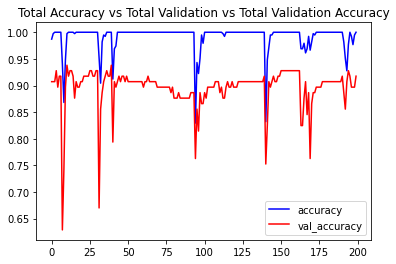

In [43]:
plot_metric(CNNLSTM_Model_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation vs Total Validation Accuracy')

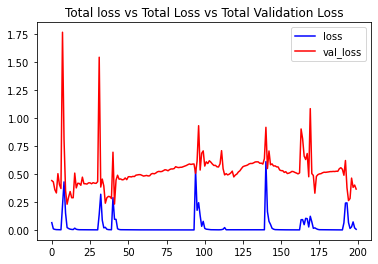

In [44]:
plot_metric(CNNLSTM_Model_history, 'loss', 'val_loss', 'Total loss vs Total Loss vs Total Validation Loss')

In [66]:
!pip install pytube

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 KB 2.0 MB/s eta 0:00:00


In [67]:
from pytube import YouTube

In [87]:
video_url = "https://www.youtube.com/watch?v=4Mg2TANphtU" 
video_url2 = "https://www.youtube.com/shorts/eem3WOPifKA" 
video_url3 = "https://www.youtube.com/watch?v=egnDl3ZlecI"
video_url4 = "https://www.youtube.com/shorts/vDI70ZqrLLI" 
video_url5 = "https://www.youtube.com/shorts/zj6AsPBoLlg" #WRONG PREDICTION


YouTube(video_url5).streams.first().download()

'/content/Guy Performs Wonderful Dance Routine While Juggling Balls - 1313407.3gpp'

In [77]:
def predict_single_action(video_file_path, SEQUENCE_LENGTH):
  video_reader = cv2.VideoCapture(video_file_path)

  orginial_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
  orginial_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))

  frames_list = []

  predicted_class_name = ''

  video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

  skip_frame_count = max(int(video_frames_count/SEQUENCE_LENGTH),1)

  for frame_counter in range(SEQUENCE_LENGTH):
    video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frame_count)
    success, frame = video_reader.read()

    if not success:
      break

    resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

    normalized_frame = resized_frame/255
    frames_list.append(normalized_frame)

  predicted_labels_probabilities = CNNLSTM_Model.predict(np.expand_dims(frames_list, axis = 0))[0]

  predicted_label = np.argmax(predicted_labels_probabilities)

  predicted_class_name = CLASSES_LIST[predicted_label]

  print(f'Action predicted: {predicted_class_name}\nConfidence: {predicted_labels_probabilities[predicted_label]}')

  video_reader.release()

In [81]:
video_path = '/content/A short push-ups video.3gpp'

In [82]:
predict_single_action(video_path, SEQUENCE_LENGTH)

1/1 [==============================] - 0s 20ms/step
Action predicted: PushUps
Confidence: 0.872283399105072


In [84]:
predict_single_action('/content/This Guy Is a Serious Nunchuck Master.3gpp', SEQUENCE_LENGTH)

1/1 [==============================] - 0s 19ms/step
Action predicted: Nunchucks
Confidence: 0.9975593090057373


In [86]:
predict_single_action('/content/Basketball skills shorts.3gpp', SEQUENCE_LENGTH)

1/1 [==============================] - 0s 26ms/step
Action predicted: Nunchucks
Confidence: 0.8690177202224731


In [88]:
predict_single_action('/content/Guy Performs Wonderful Dance Routine While Juggling Balls - 1313407.3gpp', SEQUENCE_LENGTH)

1/1 [==============================] - 0s 20ms/step
Action predicted: PushUps
Confidence: 0.9989206790924072
